In [2]:
%matplotlib inline

In [3]:
import math
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from astropy import constants as c
from astropy.table import Table
from astropy.modeling.models import Moffat1D

In [4]:
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
mpl.rcParams['figure.figsize'] = 8, 6

In [5]:
import signal_to_noise as snr

# Input data

## Optics

Aperture sizes calculated from specs. RASA area includes an FLI Microline camera sized central obstruction. 

Canon focal length value from measured pixel scale, RASA from specs.

From http://www.canon.com/camera-museum/tech/report/2011/02/ know that the Canon lens is 16 elements in 12 groups, one element and group appears to be the filter. This implies 22 air-glass interfaces, excluding the filter, one of which is has Canon's proprietary nano-structured AR coating. Can get a ball park throughput estimate as a sanity check by assuming losses averaging 0.5% at each air-glass surface (appropriate for a high quality BBAR coating).



In [6]:
0.995**22

0.8955869907338783

This is consistent with the throughput lower limit of 85% published by the Dragonfly team. We'll use a wavelength independent figure of 0.9.

From http://www.celestron.com/browse-shop/astronomy/optical-tubes/rowe-ackermann-schmidt-astrograph we know that the RASA design includes 8 transmissive air-glass interfaces, excluding the filter, plus one mirror surface. Celestron publish plots for the throughput of their Schmidt corrector plates and mirror at http://www.celestron.com/university/astronomy/starbright-xlt-optical-coating-system. We can use these data plus an assumption of 0.5% losses at the 6 remaining air-glass interfaces to estimate overall throughput as a function of wavelength.

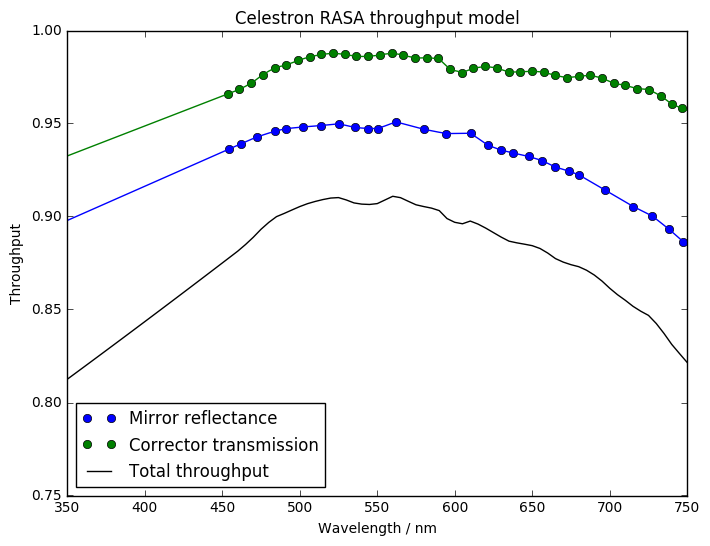

In [7]:
m = Table.read('resources/mirror.csv')
c = Table.read('resources/corrector.csv')

waves = np.arange(350,751,5)

mi = interp1d(m['Wavelength'], m['Throughput'], kind='linear', fill_value='extrapolate')
ci = interp1d(c['Wavelength'], c['Throughput'], kind='linear', fill_value='extrapolate')

tau = mi(waves) * ci(waves) * 0.995**6

rasa_tau = Table((waves, tau), names=('Wavelength', 'Throughput'))
rasa_tau['Wavelength'].unit = u.nm
rasa_tau['Throughput'].unit = u.dimensionless_unscaled
rasa_tau.write('resources/rasa_tau.csv')

plt.plot(m['Wavelength'], m['Throughput'], 'bo', label='Mirror reflectance')
plt.plot(waves, mi(waves), 'b-')
plt.plot(c['Wavelength'], c['Throughput'], 'go', label='Corrector transmission')
plt.plot(waves, ci(waves), 'g-')
plt.plot(rasa_tau['Wavelength'], rasa_tau['Throughput'], 'k-', label='Total throughput')
plt.xlabel('Wavelength / nm')
plt.ylabel('Throughput')
plt.title('Celestron RASA throughput model')
plt.ylim(0.75,1)
plt.legend(loc='best')

In [8]:
canon = snr.Optic(aperture = 139.642857143 * u.mm, \
                  focal_length = 391.0 * u.mm, \
                  throughput_filename='resources/canon_throughput.csv')

rasa= snr.Optic(aperture = 279.0 * u.mm, \
                focal_length = 620.0 * u.mm, \
                throughput_filename='resources/rasa_tau.csv', \
                central_obstruction = 129.0 * u.mm)

## Cameras

Most specifications here come from the corresponding Finger Lakes Instrumentation (FLI) [Microline camera specifications](http://www.flicamera.com/microline/index.html), with the exception of the KAF-8300M which uses the specifications for the [SBIG STF-8300M](https://www.sbig.com/products/cameras/stf-series/stf/stf-8300m/).  The read noise values used are for the lowest readout speed offered by FLI, which varies from camera to camera, and the dark current values are specified at various temperatures and are in some cases upper limits and in others 'typical' values.  Cost estimates are based on the retail prices at OptCorp in USD for a camera with a Grade 1 sensor.
sb

(0, 0.5)

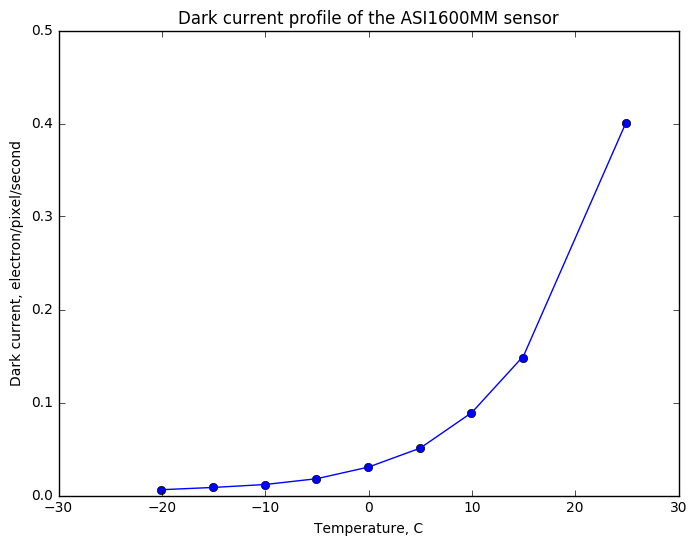

In [9]:
#Plotting the dark current versus temperature graphs for the ZWO ASI1600MM sensor
td = Table.read('resources/DarkcurrentZWO.csv')
temp = np.arange(-20, 30, 5)
tdi = interp1d(td['Temperature'], td['Dark current'], kind='linear', fill_value='extrapolate')
darkcur = tdi(temp)
plt.plot(td['Temperature'], td['Dark current'], 'bo')
plt.plot(temp, darkcur, 'b')
plt.xlabel('Temperature, C')
plt.ylabel('Dark current, electron/pixel/second')
plt.title('Dark current profile of the ASI1600MM sensor')
plt.ylim(0,0.5)

In [10]:
sbig = snr.Camera(pixel_size = 5.4 * u.micron / u.pixel, \
                  resolution = (3326, 2504) * u.pixel, \
                  read_noise = 9.3  * u.electron / u.pixel, \
                  dark_current = 0.04 * u.electron / (u.second * u.pixel), \
                  QE_filename = "resources/ML8300M_QE.csv") # Dark current 'average' at -10C

fli = snr.Camera(pixel_size = 6.0 * u.micron / u.pixel, \
                 resolution = (8176, 6132) * u.pixel, \
                 read_noise = 12.0  * u.electron / u.pixel, \
                 dark_current = 0.015 * u.electron / (u.second * u.pixel), \
                 QE_filename = "resources/ML50100_QE.csv") #Dark current at -25C
zwo = snr.Camera(pixel_size = 3.8 * u.micron / u.pixel, \
                 resolution = (4656, 3520) * u.pixel, \
                 read_noise = 2.5 * u.electron / u.pixel, \
                 dark_current = darkcur[1] * u.electron / (u.second * u.pixel), \
                 QE_filename = "resources/ZWO_QE.csv") #the value of the dark current has been approximated

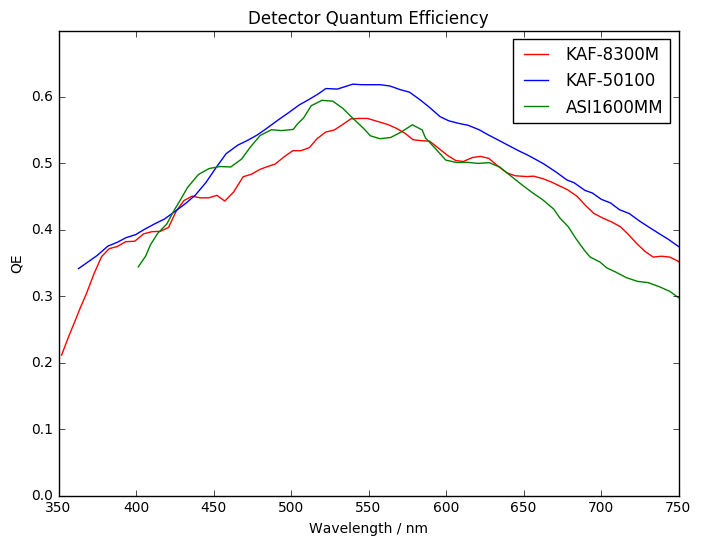

In [11]:
plt.plot(sbig.wavelengths, sbig.QE, 'r-', label='KAF-8300M')
plt.plot(fli.wavelengths, fli.QE, 'b-', label='KAF-50100')
plt.plot(zwo.wavelengths, zwo.QE, 'g-', label='ASI1600MM')
plt.xlim(350,750)
plt.ylim(0,0.7)
plt.xlabel('Wavelength / nm')
plt.ylabel('QE')
plt.legend(loc='best')
plt.title('Detector Quantum Efficiency')

## Filters

Transmission curves for Astrodon's filters are on the website. The data are assumed to be for collimated illumination, however, so may not represent the effective transmission when used with f/2.8 or f/2.2 optics. DECam g' & r' filter transmission are used as a comparison. As a modern f/2.9 instrument DECam is probably a good example of the throughout that can be achieved with fast beams. Scaling the Astrodon filter transmission down by a factor of 0.92 approximately matches the in g' and r' band average transmissions. For a conservative estimate we'll do just that. The narrowband filters are likely to be effected more by the fast beam, Astrodon's narrowband FAQ (http://astrodon.com/uploads/3/4/9/0/34905502/astrodonnarrowbandfaq.pdf) suggests 'not significant' loss at f/3 for the 5 nm filters and 15-20% loss at f/3 for the 3 nm filters. The effect of fast beams on narrowband filters is actually quite complicated (broadening the filter profile and shifting it bluewards as well as lower peak transmission) but we'll just apply a transmission scaling for now.

Sky surface brightness, g' & r' band are dark time guesstimates based on B, V, R values for Siding Spring from http://www.mso.anu.edu.au/pfrancis/reference/reference/node4.html

The H-alpha sky brightness is a guess at the average for bright time, taken as 1 magnitude above the dark sky r' band value. The full Moon sky at Siding Spring is 1.9 magnitudes brighter than the dark sky in R so given the opposition effect and an assumption of clever target selection this seems reasonable.

In [12]:
fudge_factor = 0.92

g_Astrodon = snr.Filter('resources/astrodon_g.csv', sky_mu = 22.5)
r_Astrodon = snr.Filter('resources/astrodon_r.csv', sky_mu = 21.5)
Ha_3nm = snr.Filter('resources/astrodon_ha_3nm.csv', sky_mu = 20.5)
Ha_5nm = snr.Filter('resources/astrodon_ha_5nm.csv', sky_mu = 20.5)

In [13]:
g_Astrodon.transmission *= fudge_factor
r_Astrodon.transmission *= fudge_factor
Ha_3nm.transmission *= 0.8
Ha_5nm.transmission *= fudge_factor

In [14]:
g_DECam = snr.Filter('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.g', sky_mu = 22.5)
r_DECam = snr.Filter('http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=CTIO/DECam.r', sky_mu = 21.5)

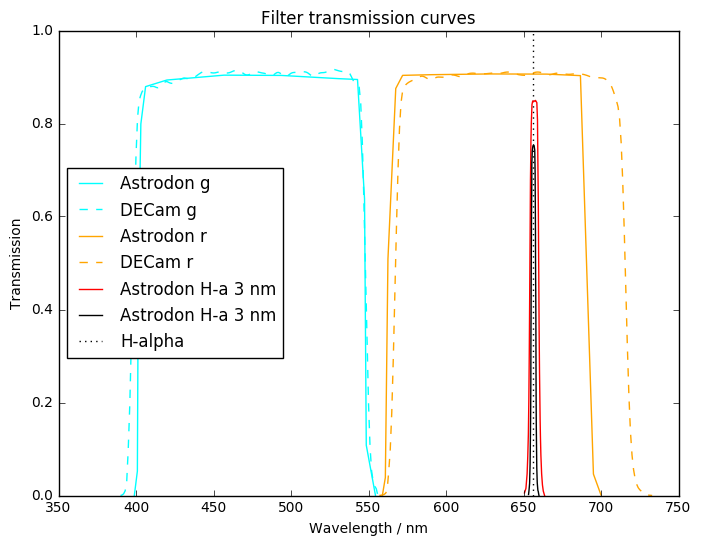

In [15]:
plt.plot(g_Astrodon.wavelengths, g_Astrodon.transmission, '-', color='cyan', label='Astrodon g')
plt.plot(g_DECam.wavelengths, g_DECam.transmission, '--', color='cyan', label='DECam g')
plt.plot(r_Astrodon.wavelengths, r_Astrodon.transmission, '-', color='orange', label='Astrodon r')
plt.plot(r_DECam.wavelengths, r_DECam.transmission, '--', color='orange', label='DECam r')
plt.plot(Ha_5nm.wavelengths, Ha_5nm.transmission, '-', color='red', label='Astrodon H-a 3 nm')
plt.plot(Ha_3nm.wavelengths, Ha_3nm.transmission, '-', color='black', label='Astrodon H-a 3 nm')
plt.vlines(656.28, 0, 1, color='black', linestyles=('dotted',), label='H-alpha')
plt.xlim(350,750)
#plt.xlim(640,670)
plt.ylim(0,1)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.legend(loc='best')
plt.title('Filter transmission curves')

## Imagers

Combine optics, filters and cameras and check for consistency with published Dragonfly calculations.

In [16]:
canon_sbig_g = snr.Imager(canon, sbig, g_Astrodon)
canon_sbig_r = snr.Imager(canon, sbig, r_Astrodon)
canon_sbig_Ha5 = snr.Imager(canon, sbig, Ha_5nm)
canon_sbig_Ha3 = snr.Imager(canon, sbig, Ha_3nm)
canon_fli_g = snr.Imager(canon, fli, g_Astrodon)
canon_fli_r = snr.Imager(canon, fli, r_Astrodon)
canon_fli_Ha5 = snr.Imager(canon, fli, Ha_5nm)
canon_fli_Ha3 = snr.Imager(canon, fli, Ha_3nm)
canon_zwo_g = snr.Imager(canon, zwo, g_Astrodon)
canon_zwo_r = snr.Imager(canon, zwo, r_Astrodon)
canon_zwo_Ha5 = snr.Imager(canon, zwo, Ha_5nm)
canon_zwo_Ha3 = snr.Imager(canon, zwo, Ha_3nm)
rasa_fli_g = snr.Imager(rasa, fli, g_Astrodon)
rasa_fli_r = snr.Imager(rasa, fli, r_Astrodon)
rasa_fli_Ha5 = snr.Imager(rasa, fli, Ha_5nm)

In [17]:
canon_zwo_g.pixel_scale

<Quantity 2.0046196003554124 arcsec / pix>

In [18]:
(canon_zwo_g.pixel_scale*canon_zwo_g.camera.resolution).to(u.degree)

<Quantity [ 2.59264135, 1.9600725 ] deg>

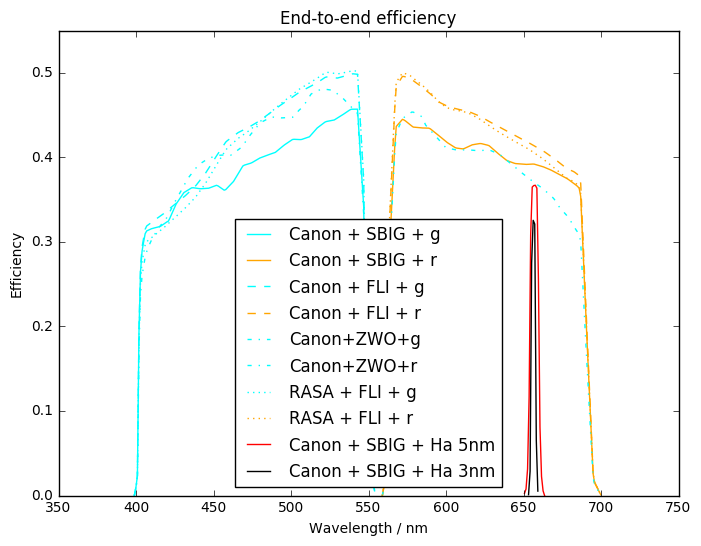

In [19]:
plt.plot(canon_sbig_g.wavelengths, canon_sbig_g.efficiencies, color='cyan', label='Canon + SBIG + g')
plt.plot(canon_sbig_r.wavelengths, canon_sbig_r.efficiencies, color='orange', label='Canon + SBIG + r')
plt.plot(canon_fli_g.wavelengths, canon_fli_g.efficiencies, '--', color='cyan', label='Canon + FLI + g')
plt.plot(canon_fli_r.wavelengths, canon_fli_r.efficiencies, '--', color='orange', label='Canon + FLI + r')
plt.plot(canon_zwo_g.wavelengths, canon_zwo_g.efficiencies, '-.', color='cyan', label='Canon+ZWO+g')
plt.plot(canon_zwo_r.wavelengths, canon_zwo_r.efficiencies, '-.', color='cyan', label='Canon+ZWO+r')
plt.plot(rasa_fli_g.wavelengths, rasa_fli_g.efficiencies, ':', color='cyan', label='RASA + FLI + g')
plt.plot(rasa_fli_r.wavelengths, rasa_fli_r.efficiencies, ':', color='orange', label='RASA + FLI + r')
plt.plot(canon_sbig_Ha5.wavelengths, canon_sbig_Ha5.efficiencies, color='red', label='Canon + SBIG + Ha 5nm')
plt.plot(canon_sbig_Ha3.wavelengths, canon_sbig_Ha3.efficiencies, color='black', label='Canon + SBIG + Ha 3nm')
plt.xlim(350,750)
plt.ylim(0,0.55)
plt.legend(loc='best')
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency')
plt.title('End-to-end efficiency')

In [20]:
canon_sbig_g.efficiency

<Quantity 0.36669591617603997 electron / ph>

In [21]:
canon_sbig_r.efficiency

<Quantity 0.3692710380230374 electron / ph>

The Dragonfly team reported a measured end-to-end efficiency (after several months without cleaning) of 34% in g' and 35% in r', i.e. within 1% of these calculated values. Estimates of filter transmission and optics throughput seem pretty good.

In [22]:
canon_sbig_g.mean_wave

<Quantity 479.5147894099945 nm>

In [23]:
canon_sbig_r.mean_wave

<Quantity 625.0704238949774 nm>

The Dragonfly team calculated mean wavelengths of 485.7 nm and 627.3 nm for the g' and r' bands based on their assumed filter transmission and detector QE curves. No serious discrepancy here.

In [24]:
canon_sbig_g.gamma0

<Quantity 1773419212.2920463 ph / (pix s)>

In [25]:
canon_sbig_r.gamma0

<Quantity 1277245076.044416 ph / (pix s)>

Using somewhat different definitions of bandwidth and effective wavelength the Dragonfly team calculated these factors as $1.79\times 10^9$ and $1.16 \times 10^9$ respectively, again no real discrepancy.

In [26]:
canon_sbig_g.ABmag_to_rate(0)

<Quantity 100245479.5302832 electron / s>

In [27]:
canon_sbig_g.SB_to_rate(0)

<Quantity 813484100.0694036 electron / (pix s)>

In [28]:
canon_sbig_g.SB_snr(26.0, total_exp_time=13000)

Rounding up total exposure time to next integer multiple of sub-exposure time: 13200.0 s


<Quantity 3.433765553856555>

In [29]:
canon_sbig_g.SB_etc(22, snr_target=5.3, sub_exp_time=60)

(<Quantity 120.0 s>, 2)

In [30]:
canon_sbig_g.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=300*u.second, N=5)

<Quantity 29.33121522653336 mag(AB)>

In [31]:
canon_sbig_g.SB_limit(total_exp_time=28 * u.hour, snr_target=5.0, sub_exp_time=300*u.second, N=5, binning=3600)

<Quantity 32.029824333535174 mag(AB)>

In [32]:
canon_sbig_r.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=300*u.second, N=5)

<Quantity 28.70939658023189 mag(AB)>

In [33]:
canon_sbig_Ha5.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=1200*u.second, N=10)

<Quantity 26.63523618636537 mag(AB)>

In [34]:
canon_sbig_Ha5.ABmag_to_flux(canon_sbig_Ha5.SB_limit(total_exp_time=28 * u.hour, snr_target=1.0, sub_exp_time=1200*u.second, N=10))

<Quantity 1.2267974426077877e-21 W / m2>

In [35]:
canon_sbig_Ha5.SB_limit(total_exp_time=28 * u.hour, snr_target=5.0, sub_exp_time=1200*u.second, N=10, binning=3600)

<Quantity 29.33416999548526 mag(AB)>

In [36]:
canon_sbig_Ha5.pivot_wave

<Quantity 656.4926763738649 nm>

In [37]:
def calculate_limits(imager, snr_calc, snr_value, number=1, value=True, no_extension=True):
    if not isinstance(imager, snr.Imager):
        raise ValueError("imager must be an instance of the Imager class")
    exptime = np.arange(10,1001 if no_extension else 2001 ,10) * u.second
    limit_all= u.Quantity([imager.SB_limit(t if value else 28*u.hour, snr_target=snr_value, sub_exp_time=t, snr_calculation=snr_calc, N=number) for t in exptime])
    limit_noread= u.Quantity([imager.SB_limit(t if value else 28*u.hour, snr_target=snr_value, sub_exp_time=t, snr_calculation=snr_calc, N=number, enable_read_noise=False) for t in exptime])
    limit_skyonly= u.Quantity([imager.SB_limit(t if value else 28*u.hour, snr_target=snr_value, sub_exp_time=t, snr_calculation=snr_calc, N=number, enable_read_noise=False, enable_dark_noise=False) \
        for t in exptime])
    return (exptime, limit_all, limit_noread, limit_skyonly)

In [38]:
ts, sg, sgr, sgi = calculate_limits(canon_sbig_g, 'per pixel', 3.0)
ts, sr, srr, sri = calculate_limits(canon_sbig_r, 'per pixel', 3.0)
ts, sg1, sgr1, sgi1 = calculate_limits(canon_fli_g,'per pixel', 3.0)
ts, sr1, srr1, sri1 = calculate_limits(canon_fli_r,'per pixel', 3.0)
ts, sg2, sgr2, sgi2 = calculate_limits(rasa_fli_g,'per pixel', 3.0)
ts, sr2, srr2, sri2 = calculate_limits(rasa_fli_r,'per pixel', 3.0)
ts, sg3, sgr3, sgi3 = calculate_limits(canon_zwo_g, 'per pixel', 3.0)
ts, sr3, srr3, sri3 = calculate_limits(canon_zwo_r, 'per pixel', 3.0)

In [39]:
ts, lg, lgr, lgi = calculate_limits(canon_sbig_g, 'per arcseconds squared', 1.0)
ts, lr, lrr, lri = calculate_limits(canon_sbig_r, 'per arcseconds squared', 1.0)
ts, lg1, lgr1, lgi1 = calculate_limits(canon_fli_g,'per arcseconds squared', 1.0)
ts, lr1, lrr1, lri1 = calculate_limits(canon_fli_r,'per arcseconds squared', 1.0)
ts, lg2, lgr2, lgi2 = calculate_limits(rasa_fli_g,'per arcseconds squared', 1.0)
ts, lr2, lrr2, lri2 = calculate_limits(rasa_fli_r,'per arcseconds squared', 1.0)
ts, lg3, lgr3, lgi3 = calculate_limits(canon_zwo_g, 'per arcseconds squared', 1.0)
ts, lr3, lrr3, lri3 = calculate_limits(canon_zwo_r, 'per arcseconds squared', 1.0)

In [40]:
ts, pg, pgr, pgi = calculate_limits(canon_sbig_g, 'per arcseconds squared', 1.0, 5)
ts, pr, prr, pri = calculate_limits(canon_sbig_r, 'per arcseconds squared', 1.0, 5)
tsh, ph, phr, phi = calculate_limits(canon_sbig_Ha5,'per arcseconds squared', 1.0, 5, no_extension=False)
ts, pg1, pgr1, pgi1 = calculate_limits(canon_fli_g,'per arcseconds squared', 1.0, 5)
ts, pr1, prr1, pri1 = calculate_limits(canon_fli_r,'per arcseconds squared', 1.0, 5)
tsh, ph1, phr1, phi1 = calculate_limits(canon_fli_Ha5,'per arcseconds squared', 1.0, 5, no_extension=False)
ts, pg2, pgr2, pgi2 = calculate_limits(rasa_fli_g,'per arcseconds squared', 1.0, 2)
ts, pr2, prr2, pri2 = calculate_limits(rasa_fli_r,'per arcseconds squared', 1.0, 2)
tsh, ph2, phr2, phi2 = calculate_limits(rasa_fli_Ha5,'per arcseconds squared', 1.0, 2, no_extension=False)
ts, pg3, pgr3, pgi3 = calculate_limits(canon_zwo_g, 'per arcseconds squared', 1.0, 5)
ts, pr3, prr3, pri3 = calculate_limits(canon_zwo_r, 'per arcseconds squared', 1.0, 5)
tsh, ph3, phr3, phi3 = calculate_limits(canon_zwo_Ha5,'per arcseconds squared', 1.0, 5, no_extension=False)

In [41]:
ts, qg, qgr, qgi = calculate_limits(canon_sbig_g, 'per arcseconds squared', 1.0, 5, False)
ts, qr, qrr, qri = calculate_limits(canon_sbig_r, 'per arcseconds squared', 1.0, 5, False)
tsh, qh, qhr, qhi = calculate_limits(canon_sbig_Ha5, 'per arcseconds squared', 1.0, 5, False, False)
ts, qg1, qgr1, qgi1 = calculate_limits(canon_fli_g,'per arcseconds squared', 1.0, 5, False)
ts, qr1, qrr1, qri1 = calculate_limits(canon_fli_r,'per arcseconds squared', 1.0, 5, False)
tsh, qh1, qhr1, qhi1 = calculate_limits(canon_fli_Ha5,'per arcseconds squared', 1.0, 5, False, False)
ts, qg2, qgr2, qgi2 = calculate_limits(rasa_fli_g,'per arcseconds squared', 1.0, 2, False)
ts, qr2, qrr2, qri2 = calculate_limits(rasa_fli_r,'per arcseconds squared', 1.0, 2, False)
tsh, qh2, qhr2, qhi2 = calculate_limits(rasa_fli_Ha5,'per arcseconds squared', 1.0, 2, False, False)
ts, qg3, qgr3, qgi3 = calculate_limits(canon_zwo_g, 'per arcseconds squared', 1.0, 5, False)
ts, qr3, qrr3, qri3 = calculate_limits(canon_zwo_r, 'per arcseconds squared', 1.0, 5, False)
tsh, qh3, qhr3, qhi3 = calculate_limits(canon_zwo_Ha5, 'per arcseconds squared', 1.0, 5, False, False)

Rounding up total exposure time to next integer multiple of sub-exposure time: 100870.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100880.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100810.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100890.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100980.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100970.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 101000.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100880.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100980.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 100920.0 s
Rounding up total exposure time to next integer multiple of sub-exposure time: 101060.0 s
Rounding u

In [42]:
def sensitivity_plot(times, data1, data2, data3, plot_number, colour, name, num_rows=2):
    plt.subplot(num_rows,1,plot_number)
    plt.semilogx(times, data1, '{}-'.format(colour), label='{} all noise sources'.format(name))
    plt.semilogx(times, data2, '{}--'.format(colour), label='{} no read noise'.format(name))
    plt.semilogx(times, data3, '{}:'.format(colour), label='{} sky noise only'.format(name))

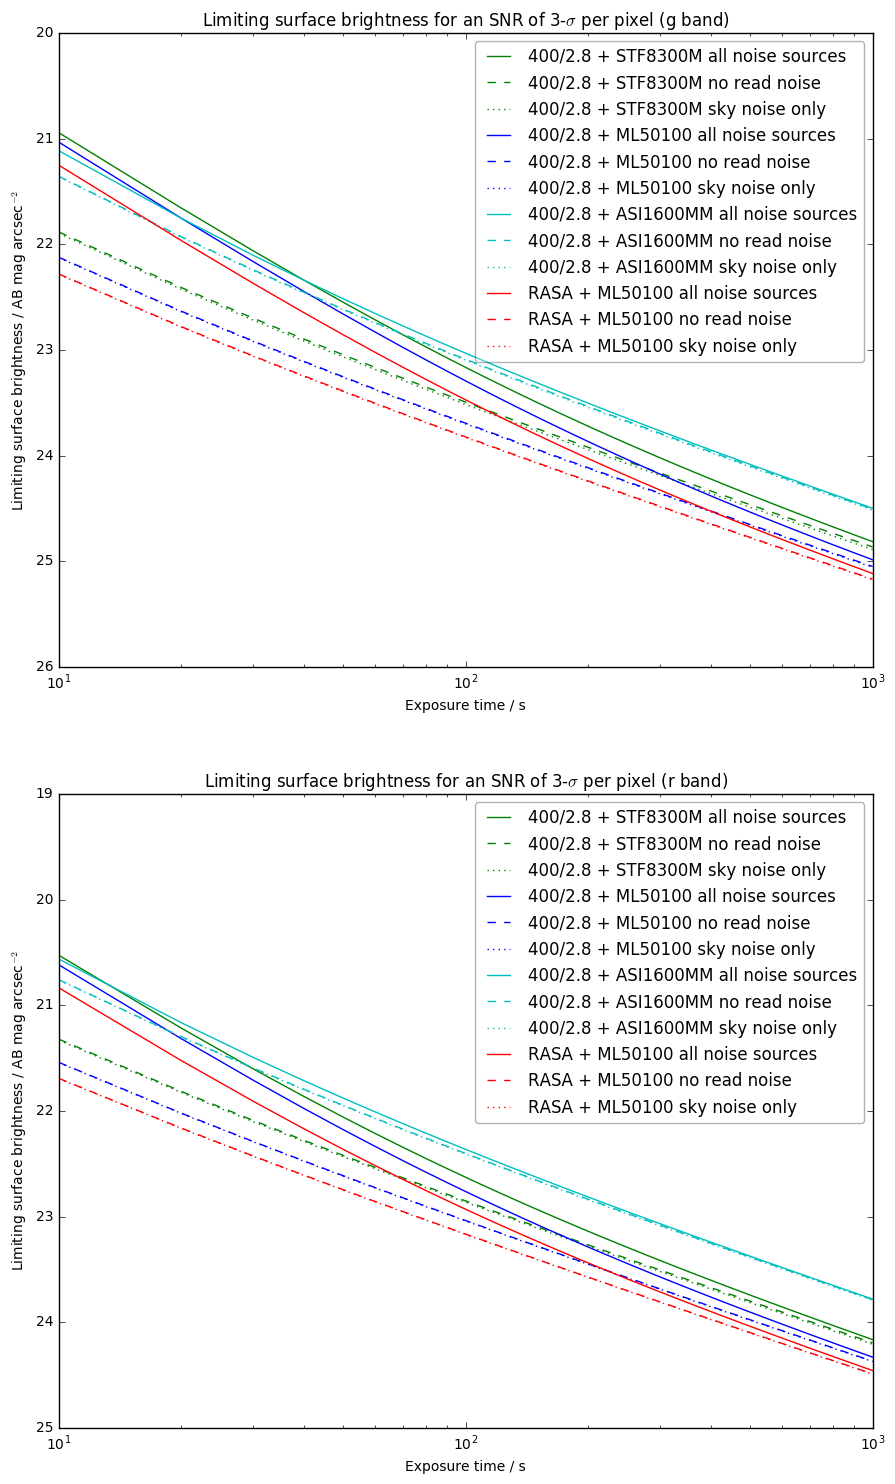

In [43]:
sensitivity_plot(ts, sg, sgr, sgi, 1, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, sr, srr, sri, 2, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, sg1, sgr1, sgi1, 1, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, sr1, srr1, sri1, 2, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, sg3, sgr3, sgi3, 1, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, sr3, srr3, sri3, 2, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, sg2, sgr2, sgi2, 1, 'r', 'RASA + ML50100')
sensitivity_plot(ts, sr2, srr2, sri2, 2, 'r', 'RASA + ML50100')
plt.subplot(2,1,1)
plt.ylim(26,20)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 3-$\sigma$ per pixel (g band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(2,1,2)
plt.ylim(25,19)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 3-$\sigma$ per pixel (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,18)
plt.savefig('sensitivityplot.png')

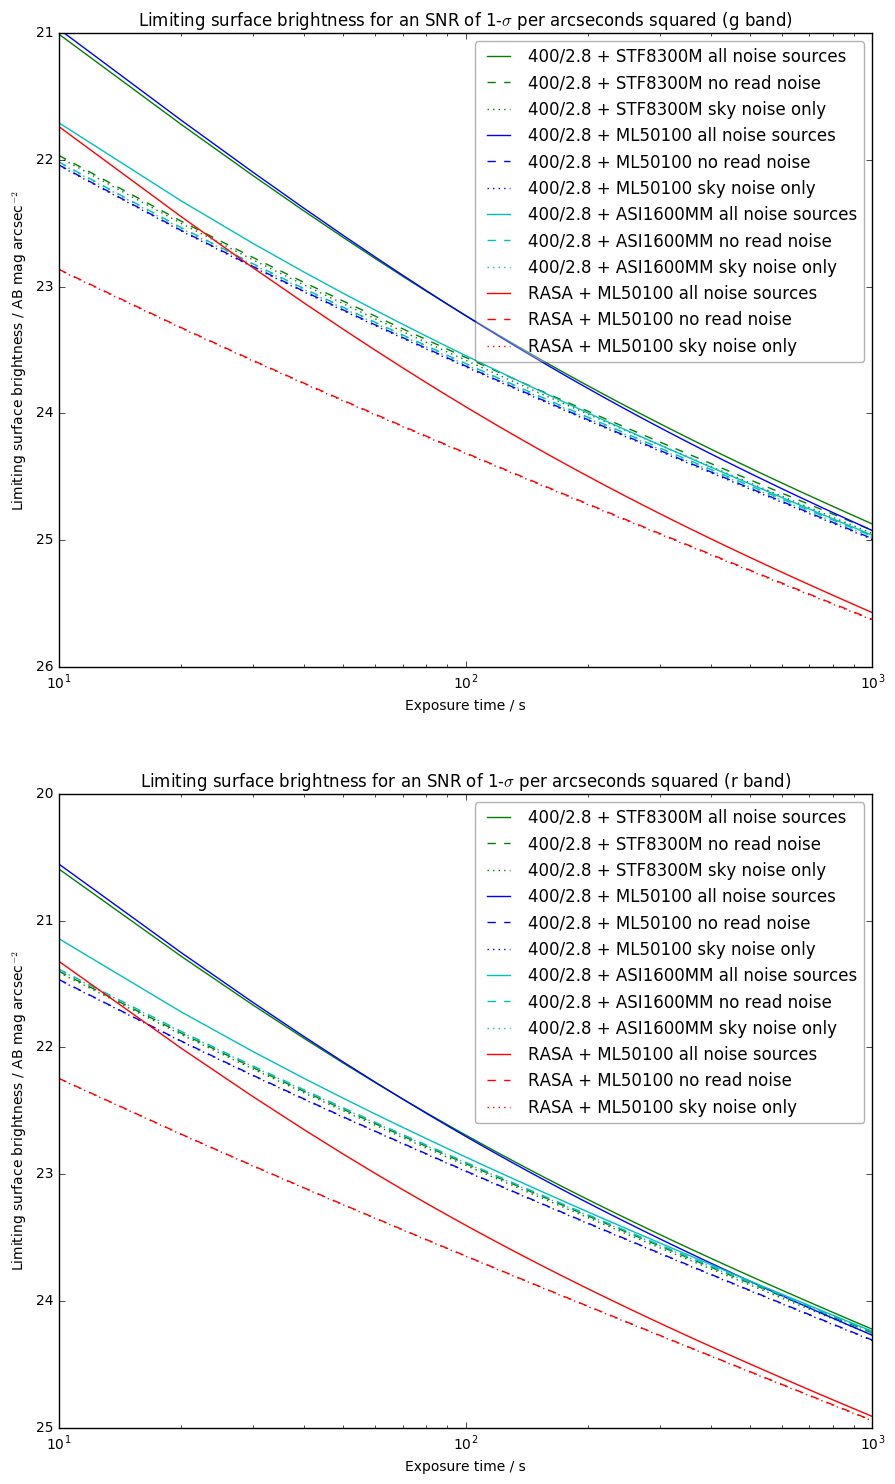

In [44]:

sensitivity_plot(ts, lg, lgr, lgi, 1, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, lr, lrr, lri, 2, 'g', '400/2.8 + STF8300M')
sensitivity_plot(ts, lg1, lgr1, lgi1, 1, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, lr1, lrr1, lri1, 2, 'b', '400/2.8 + ML50100')
sensitivity_plot(ts, lg3, lgr3, lgi3, 1, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, lr3, lrr3, lri3, 2, 'c', '400/2.8 + ASI1600MM')
sensitivity_plot(ts, lg2, lgr2, lgi2, 1, 'r', 'RASA + ML50100')
sensitivity_plot(ts, lr2, lrr2, lri2, 2, 'r', 'RASA + ML50100')
plt.subplot(2,1,1)
plt.ylim(26,21)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (g band)')
plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.subplot(2,1,2)
plt.ylim(25,20)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,18)
plt.savefig('sensitivityplot1.png')

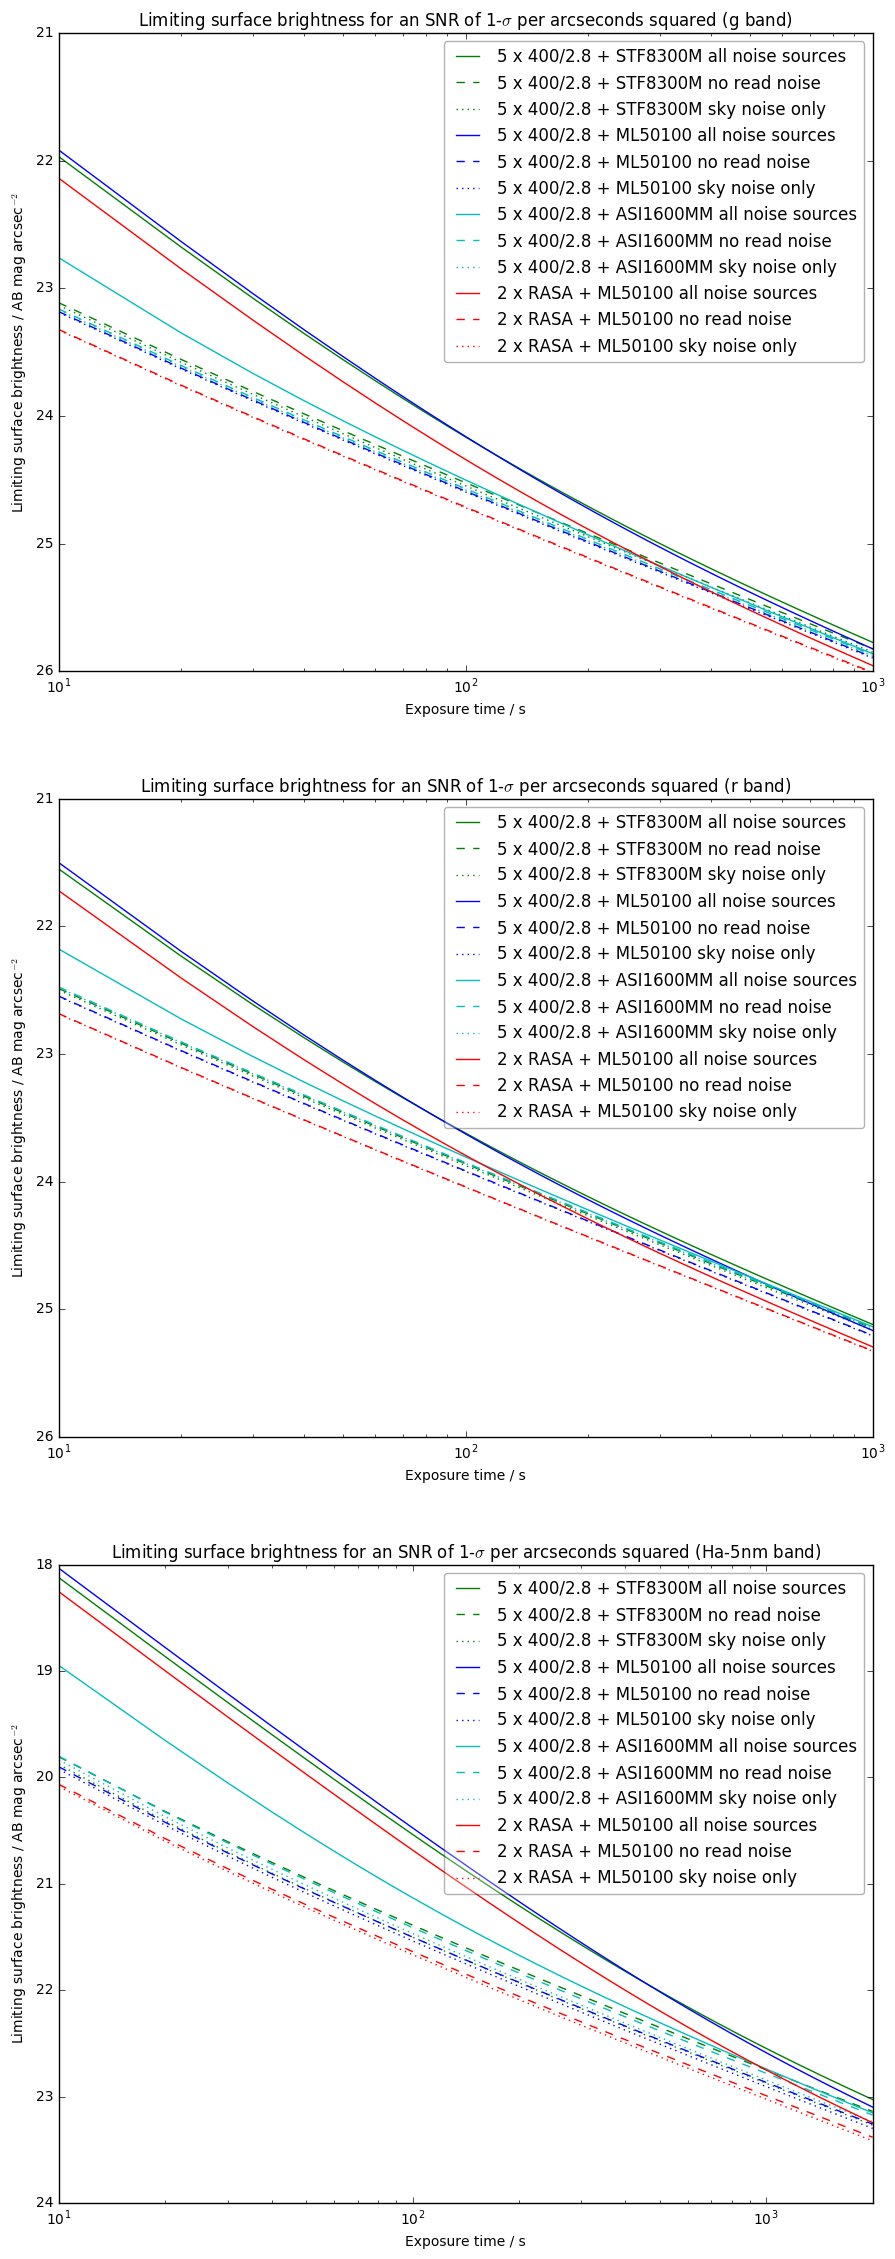

In [45]:
sensitivity_plot(ts, pg, pgr, pgi, 1, 'g', '5 x 400/2.8 + STF8300M', 3) 
sensitivity_plot(ts, pr, prr, pri, 2, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(tsh, ph, phr, phi, 3, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, pg1, pgr1, pgi1, 1, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, pr1, prr1, pri1, 2, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(tsh, ph1, phr1, phi1, 3, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, pg3, pgr3, pgi3, 1, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, pr3, prr3, pri3, 2, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(tsh, ph3, phr3, phi3, 3, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, pg2, pgr2, pgi2, 1, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(ts, pr2, prr2, pri2, 2, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(tsh, ph2, phr2, phi2, 3, 'r', '2 x RASA + ML50100', 3)
plt.subplot(3,1,1)
plt.ylim(26,21)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (g band)')
plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.subplot(3,1,2)
plt.ylim(26,21)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,3)
plt.xlim(10, 2000)
plt.ylim(24,18)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcseconds squared (Ha-5nm band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,28)
plt.savefig('sensitivityplot2.png')

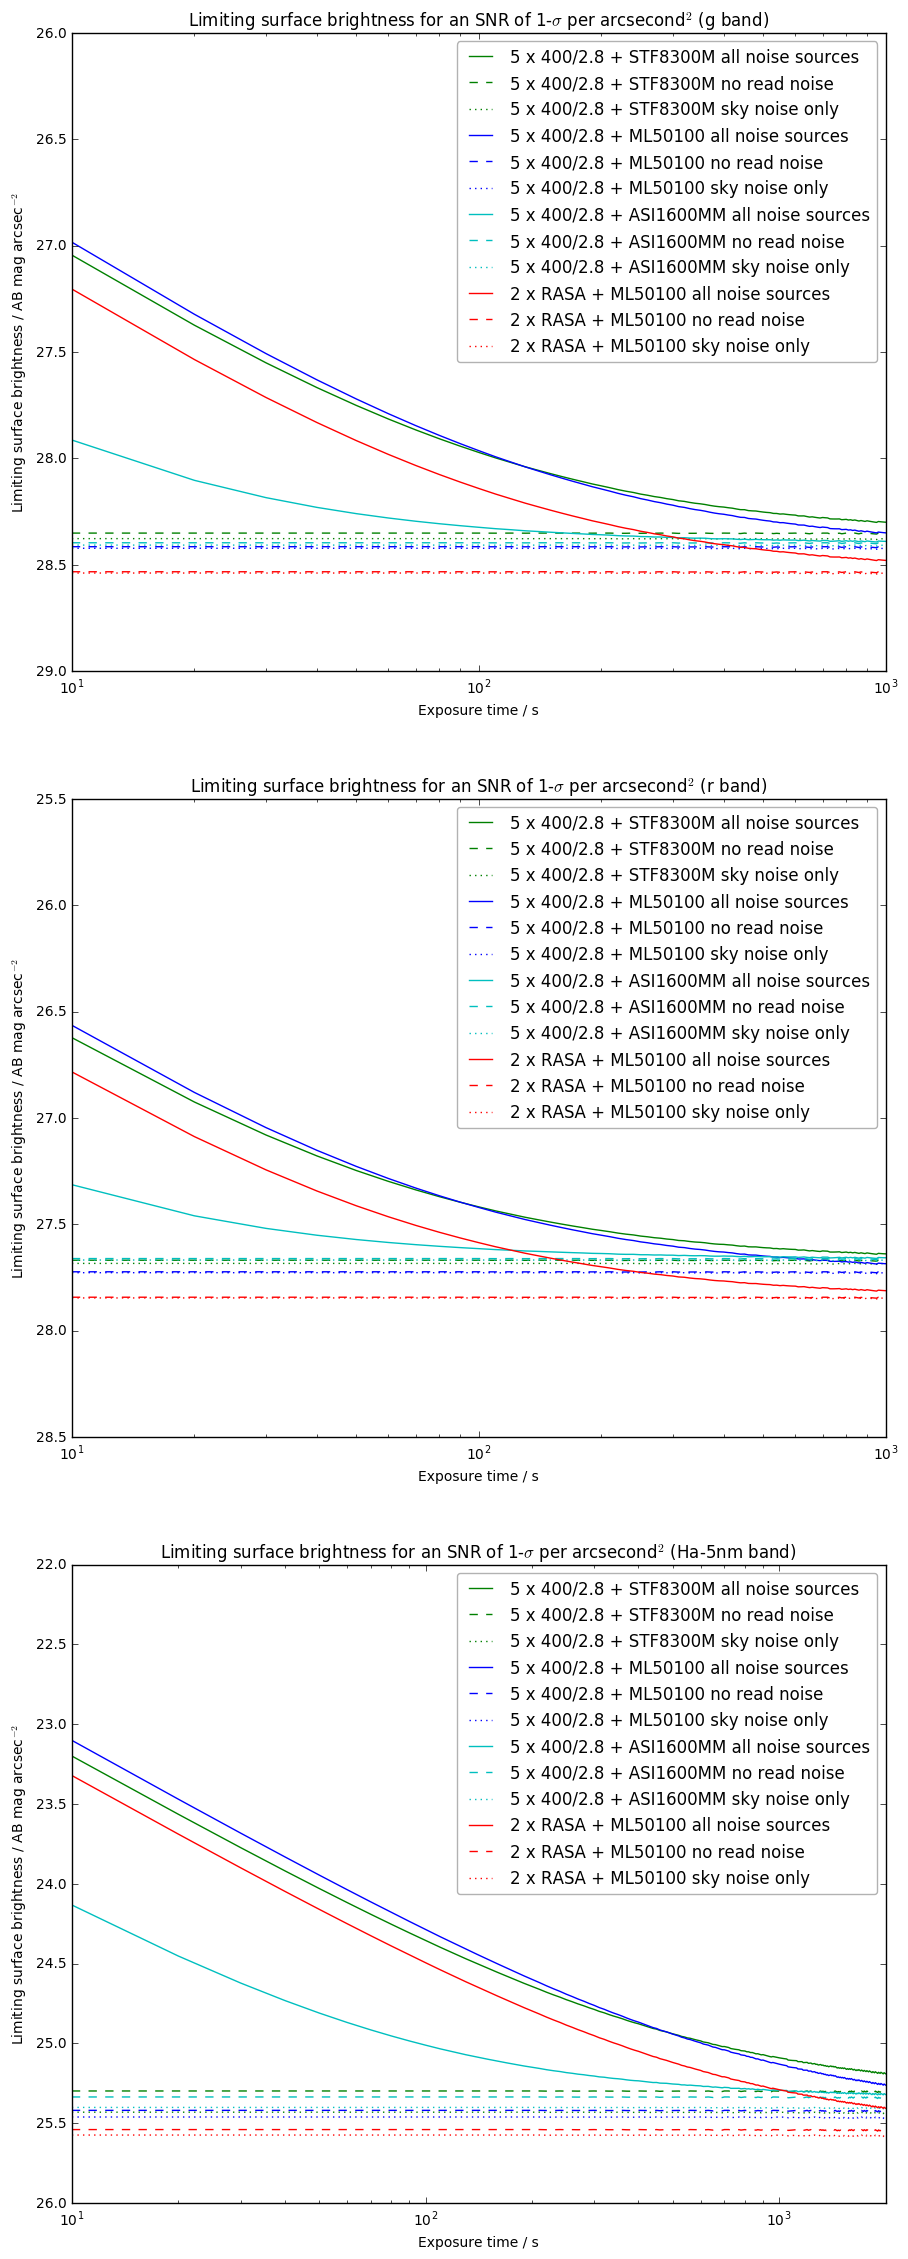

In [46]:
sensitivity_plot(ts, qg, qgr, qgi, 1, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, qr, qrr, qri, 2, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(tsh, qh, qhr, qhi, 3, 'g', '5 x 400/2.8 + STF8300M', 3)
sensitivity_plot(ts, qg1, qgr1, qgi1, 1, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, qr1, qrr1, qri1, 2, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(tsh, qh1, qhr1, qhi1, 3, 'b', '5 x 400/2.8 + ML50100', 3)
sensitivity_plot(ts, qg3, qgr3, qgi3, 1, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, qr3, qrr3, qri3, 2, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(tsh, qh3, qhr3, qhi3, 3, 'c', '5 x 400/2.8 + ASI1600MM', 3)
sensitivity_plot(ts, qg2, qgr2, qgi2, 1, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(ts, qr2, qrr2, qri2, 2, 'r', '2 x RASA + ML50100', 3)
sensitivity_plot(tsh, qh2, qhr2, qhi2, 3, 'r', '2 x RASA + ML50100', 3)
plt.subplot(3,1,1)
plt.ylim(29,26)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcsecond$^2$ (g band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,2)
plt.ylim(28.5,25.5)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcsecond$^2$ (r band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.subplot(3,1,3)
plt.xlim(10, 2000)
plt.ylim(26,22)
plt.xlabel('Exposure time / s')
plt.ylabel('Limiting surface brightness / AB mag arcsec$^{-2}$')
plt.title('Limiting surface brightness for an SNR of 1-$\sigma$ per arcsecond$^2$ (Ha-5nm band)')
plt.legend(loc='best', fancybox=True, framealpha=0.3)
plt.gcf().set_size_inches(10.5,28)
plt.savefig('sensitivityplot3.png')

In [47]:
#generating a table showing limiting magnitudes of different imagers for different single exposure times for the g band
exp_time=[10, 30, 100, 300, 1000]
canon_sbig_gband=[pg[0].value , pg[2].value, pg[9].value, pg[29].value, pg[-1].value]
canon_fli_gband=[pg1[0].value, pg1[2].value, pg1[9].value, pg1[29].value, pg1[-1].value]
rasa_fli_gband=[pg2[0].value, pg2[2].value, pg2[9].value, pg2[29].value, pg2[-1].value]
canon_zwo_gband=[pg3[0].value, pg3[2].value, pg3[9].value, pg3[29].value, pg3[-1].value]
comparison_table_g = Table([exp_time, canon_sbig_gband, canon_fli_gband, canon_zwo_gband, rasa_fli_gband], names=('Exposure time', '5 x 400/2.8 + STF8300M', '5 x 400/2.8 + ML50100',\
                                                                                '5 x 400/2.8 + ASI1600MM', '2 x RASA + ML50100'))
comparison_table_g['Exposure time'].unit=u.second
comparison_table_g['5 x 400/2.8 + STF8300M'].unit=u.ABmag
comparison_table_g['5 x 400/2.8 + ML50100'].unit=u.ABmag
comparison_table_g['5 x 400/2.8 + ASI1600MM'].unit=u.ABmag
comparison_table_g['2 x RASA + ML50100'].unit=u.ABmag
comparison_table_g.write('resources/comparison_table_gband.csv')
comparison_table_g.show_in_notebook(show_row_index=False)

Exposure time,5 x 400/2.8 + STF8300M,5 x 400/2.8 + ML50100,5 x 400/2.8 + ASI1600MM,2 x RASA + ML50100
s,mag(AB),mag(AB),mag(AB),mag(AB)
10,21.9697869801,21.918191651,22.7616401404,22.1391470228
30,23.0785198591,23.0425352843,23.6676579236,23.2502169383
100,24.166341906,24.1623997082,24.5025333225,24.3424765179
300,25.0000408794,25.0285711132,25.1738048965,25.1800423398
1000,25.7740289697,25.8248297925,25.8635151219,25.9560019864


In [48]:
#generating a table showing limiting magnitudes of different imagers for different single exposure times for the r band
exp_time=[10, 30, 100, 300, 1000]
canon_sbig_rband=[pr[0].value , pr[2].value, pr[9].value, pr[29].value, pr[-1].value]
canon_fli_rband=[pr1[0].value, pr1[2].value, pr1[9].value, pr1[29].value, pr1[-1].value]
rasa_fli_rband=[pr2[0].value, pr2[2].value, pr2[9].value, pr2[29].value, pr2[-1].value]
canon_zwo_rband=[pr3[0].value, pr3[2].value, pr3[9].value, pr3[29].value, pr3[-1].value]
comparison_table_r= Table([exp_time, canon_sbig_rband, canon_fli_rband, canon_zwo_rband, rasa_fli_rband], names=('Exposure time', '5 x 400/2.8 + STF8300M', '5 x 400/2.8 + ML50100',\
                                                                                '5 x 400/2.8 + ASI1600MM', '2 x RASA + ML50100'))
#comparison_table_r.remove_column('idx')
comparison_table_r['Exposure time'].unit=u.second
comparison_table_r['5 x 400/2.8 + STF8300M'].unit=u.ABmag
comparison_table_r['5 x 400/2.8 + ML50100'].unit=u.ABmag
comparison_table_r['5 x 400/2.8 + ASI1600MM'].unit=u.ABmag
comparison_table_r['2 x RASA + ML50100'].unit=u.ABmag
comparison_table_r.write('resources/comparison_table_rband.csv')
comparison_table_r.show_in_notebook(show_row_index=False)

Exposure time,5 x 400/2.8 + STF8300M,5 x 400/2.8 + ML50100,5 x 400/2.8 + ASI1600MM,2 x RASA + ML50100
s,mag(AB),mag(AB),mag(AB),mag(AB)
10,21.5502585329,21.5006722157,22.1772372655,21.720724536
30,22.6128194187,22.5844274631,23.0195398502,22.7848528179
100,23.6198185454,23.6258811014,23.8060275171,23.7939545737
300,24.3853346292,24.4177083771,24.4557570701,24.5604682305
1000,25.1176994373,25.1646003863,25.1353229851,25.2927905769


In [49]:
#generating a table showing limiting magnitudes of different imagers for different single exposure times for the Ha-5nm band
exp_time=[10, 30, 100, 300, 1000]
canon_sbig_Ha5band=[ph[0].value , ph[2].value, ph[9].value, ph[29].value, ph[-1].value]
canon_fli_Ha5band=[ph1[0].value, ph1[2].value, ph1[9].value, ph1[29].value, ph1[-1].value]
rasa_fli_Ha5band=[ph2[0].value, ph2[2].value, ph2[9].value, ph2[29].value, ph2[-1].value]
canon_zwo_Ha5band=[ph3[0].value, ph3[2].value, ph3[9].value, ph3[29].value, ph3[-1].value]
comparison_table_Ha5 = Table([exp_time, canon_sbig_Ha5band, canon_fli_Ha5band, canon_zwo_Ha5band, rasa_fli_Ha5band], names=('Exposure time', '5 x 400/2.8 + STF8300M', '5 x 400/2.8 + ML50100',\
                                                                                '5 x 400/2.8 + ASI1600MM', '2 x RASA + ML50100'))
#comparison_table_r.remove_column('idx')
comparison_table_Ha5['Exposure time'].unit=u.second
comparison_table_Ha5['5 x 400/2.8 + STF8300M'].unit=u.ABmag
comparison_table_Ha5['5 x 400/2.8 + ML50100'].unit=u.ABmag
comparison_table_Ha5['5 x 400/2.8 + ASI1600MM'].unit=u.ABmag
comparison_table_Ha5['2 x RASA + ML50100'].unit=u.ABmag
comparison_table_Ha5.write('resources/comparison_table_Ha-5nmband.csv')
comparison_table_Ha5.show_in_notebook(show_row_index=False)

Exposure time,5 x 400/2.8 + STF8300M,5 x 400/2.8 + ML50100,5 x 400/2.8 + ASI1600MM,2 x RASA + ML50100
s,mag(AB),mag(AB),mag(AB),mag(AB)
10,18.1220634206,18.0336799452,18.9472840225,18.2543397476
30,19.2942602009,19.2125226952,20.0506144504,19.4303849067
100,20.5350998597,20.473575889,21.1304128942,20.6827938042
300,21.5744429517,21.5531673874,21.9615446051,21.7445574878
1000,23.027906714,23.0988875928,23.1527420176,23.2461498866


In [50]:
2.8/2.2

1.2727272727272725

In [51]:
x=(2.8/2.2)**2
10**(-0.4*x)

0.22493970212948952

In [52]:
lgi2[0]-lgi1[0]

<Quantity 0.8234548310686165 mag(AB)>

In [53]:
lgi1[0]

<Quantity 22.04469181943976 mag(AB)>

In [54]:
canon_sbig_g.pixel_area


<Quantity 8.1149205318895 arcsec2 / pix>

In [55]:
canon_sbig_r.pixel_area


<Quantity 8.1149205318895 arcsec2 / pix>

In [56]:
canon_fli_r.pixel_area

<Quantity 10.018420409740122 arcsec2 / pix>

In [57]:
rasa_fli_r.pixel_area

<Quantity 3.9844592368925063 arcsec2 / pix>

In [58]:
x=np.sqrt(rasa.aperture_area/canon.aperture_area)
y=np.log(x)
z=y/0.4
print(z)

1.4296577286124459


In [59]:
lgi2[0]-lgi1[0]

<Quantity 0.8234548310686165 mag(AB)>

In [259]:
def moffatprofile(imager):
    plt.figure()
    s1 = Moffat1D()
    r = np.arange(0, 20, .005)
    s1.alpha = 4.765 #standard value for the seeing parameter
    s1.gamma = 1/(2**(1/s1.alpha) - 1)**0.5 #using a FWHM value of 2 arcseconds and the relationship between alpha, gamma and FWHM
    s1.amplitude = ((s1.alpha-1)/(np.pi * s1.gamma**2)) * imager.ABmag_to_rate(10).value #assuming the point source to be of 10th magnitude
    plt.plot(r, s1(r), color=str(0.25), lw=2)
    area= np.trapz(2*np.pi*r*s1(r), r) #calculating the area under the curve
    plt.axis([0, 20, 0, 2000])
    plt.xlabel('radius / arcsec')
    plt.ylabel('Signal rate / electron second$^{-1}$ arcsec$^{-2}$')
    plt.title('Moffat Distribution for a point source with a magnitude of 6 AB mag')
    plt.show()
    plt.savefig('Moffatprofile.png')
    print (area/imager.ABmag_to_rate(10).value) #checking to see if the area is normalized when the total flux is taken out
    return s1

In [260]:
def snr_calculation(p, imager, intensityfunc, total_exp_time, sub_exp_time=1000 * u.second, binning=1, N=1):
    
    radius=np.arange(0,p,0.005)
    signal_rate = (np.trapz(2*np.pi*radius*intensityfunc(radius), radius)*u.electron)/(u.second)
    total_exp_time *= u.second
    number_subs = int(math.ceil(total_exp_time/sub_exp_time))
        
    if (total_exp_time != number_subs * sub_exp_time):
        total_exp_time = number_subs * sub_exp_time
        print('Rounding up total exposure time to next integer multiple of sub-exposure time:', total_exp_time)
    
    # Noise sources
    signal = (signal_rate * total_exp_time).to(u.electron)
    sky_counts = ((imager.sky_rate * np.pi * (p**2) * (u.arcsecond ** 2) * total_exp_time)/(imager.pixel_area)).to(u.electron)
    dark_counts = ((imager.camera.dark_current * np.pi * (p**2) * (u.arcsecond ** 2) * total_exp_time)/(imager.pixel_area)).to(u.electron)
    total_read_noise = (((number_subs)**0.5 * imager.camera.read_noise * np.pi * (p**2) * (u.arcsecond ** 2))/(imager.pixel_area)).to(u.electron)
    
    noise = (signal.value + sky_counts.value + dark_counts.value + total_read_noise.value**2)**0.5
    noise *= u.electron
    
    signaltonoise = (N * binning)**0.5 * signal/noise # Number of optics in array or pixel binning increases snr as n^0.5
        
    return signaltonoise.to(u.dimensionless_unscaled)
snr_calculation2 = np.vectorize(snr_calculation)

In [265]:
def plotintensityprof(imager, intensityfunc):  
    x = np.arange(0.005,20.005,0.005)
    plt.plot(x, snr_calculation2(x, imager, intensityfunc, 1000), color=str(0.1), lw=2)
    plt.axis([0, 10, 0, 5000])
    plt.xlabel('radius / arcsec')
    plt.ylabel('Signal to noise ratio / sigma per arcsec$^{-2}$')
    plt.title('Signal to noise ratio for a point source with a magnitude of 13 AB mag')
    plt.show()
    plt.savefig('snrMoffat.png')

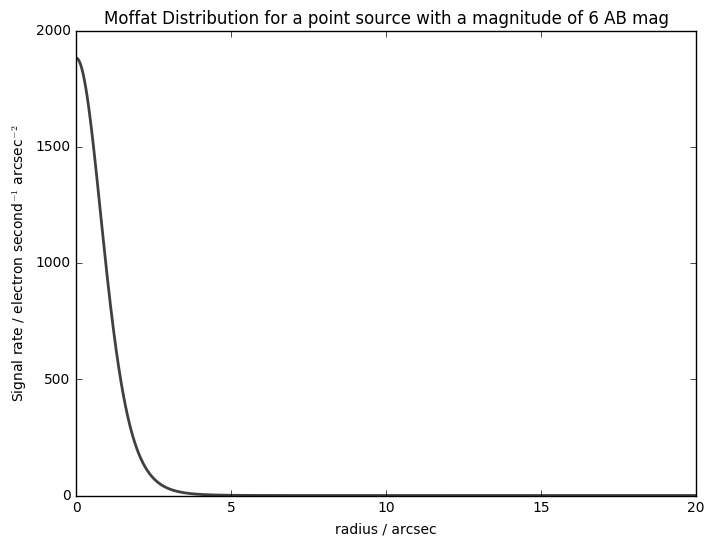

0.999997381492


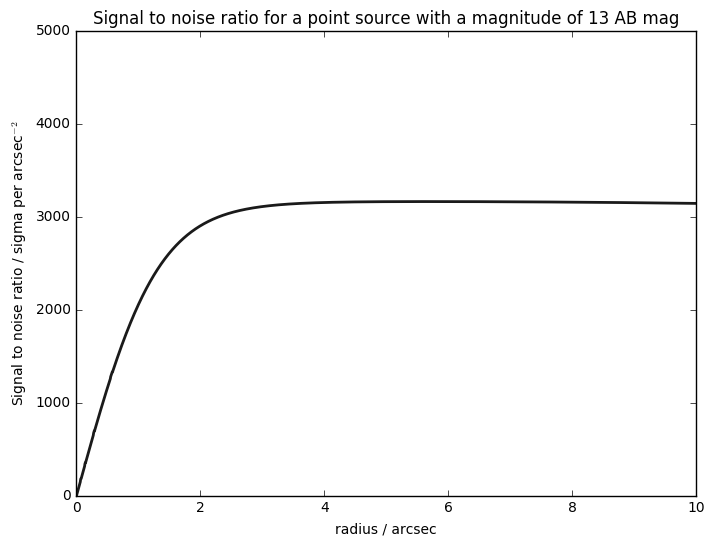

In [266]:
plotintensityprof(canon_sbig_g, moffatprofile(canon_sbig_g))

In [233]:
canon_sbig_g.ABmag_to_rate(10)

<Quantity 10024.547953028321 electron / s>

In [110]:
print (canon_fli_r.camera.pixel_size)
    

6.0 micron / pix
